# Predict single footballer future points with LSTM (notebook deprecated)
**NOTE: I initially tried to use the LSTM model, but after more thought, I decided to use the MLP model.**

## Import merged_gw data from 2020-21 season

In [24]:
import os
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [25]:
data_path = os.path.dirname(os.getcwd()) + '\\data\\Fantasy-Premier-League'
merged_gw_2021_path = data_path + '\\2020-21\\gws\\merged_gw.csv'

In [26]:
merged_gw_2021 = pd.read_csv(merged_gw_2021_path, encoding='latin-1')

In [27]:
merged_gw_2021.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,78,...,1,32.0,1,0,0,0,55,True,0,1
1,Aaron Cresswell,DEF,West Ham,2.1,0,0,11,0,11.2,435,...,0,0.0,1,0,0,0,50,True,0,1
2,Aaron Mooy,MID,Brighton,0.0,0,0,0,0,0.0,60,...,1,0.0,0,0,0,0,50,True,0,1
3,Aaron Ramsdale,GK,Sheffield Utd,2.5,0,0,12,0,0.0,483,...,0,0.0,1,0,0,0,50,True,0,1
4,Abdoulaye DoucourÃ©,MID,Everton,1.3,0,0,20,1,44.6,512,...,0,4.0,3,0,0,0,55,False,0,1


In [28]:
# sort rows by column 'GW' ascending
merged_gw_2021.sort_values(by='GW', inplace=True)

## Extract Jamie Vardy data

In [29]:
vardy_data = merged_gw_2021[merged_gw_2021['name'] == 'Jamie Vardy']

In [30]:
vardy_data.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
183,Jamie Vardy,FWD,Leicester,4.8,0,3,52,1,10.3,224,...,0,36.0,13,0,0,0,100,False,0,1
660,Jamie Vardy,FWD,Leicester,8.0,0,0,6,0,11.2,224,...,4,22.0,2,226309,303351,77042,101,True,0,2
1207,Jamie Vardy,FWD,Leicester,10.2,0,3,82,0,0.5,224,...,2,71.0,17,-247620,71441,319061,100,False,0,3
1764,Jamie Vardy,FWD,Leicester,9.0,0,0,-2,0,1.4,224,...,0,14.0,2,296313,427289,130976,101,True,0,4
2335,Jamie Vardy,FWD,Leicester,4.3,0,0,0,0,0.0,224,...,0,0.0,0,-30736,210612,241348,101,True,0,5


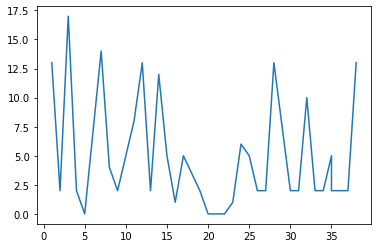

In [31]:
plt.plot(vardy_data['GW'], vardy_data['total_points']);

## Data preprocessing

In [32]:
cleaned_data = vardy_data.drop(['name', 'position', 'team', 'element', 'fixture', 'kickoff_time', 'saves', 'penalties_saved', 'round', 'GW'], axis=1)

In [33]:
# change was_home column to binary
cleaned_data['was_home'] = cleaned_data['was_home'].map({True: 1, False: 0})

In [34]:
# one hot encode 'opponent_team' column
cleaned_data = pd.get_dummies(cleaned_data, columns=['opponent_team'], drop_first=True)

In [35]:
cleaned_data.head()

,xP,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,opponent_team_11,opponent_team_12,opponent_team_13,opponent_team_14,opponent_team_15,opponent_team_16,opponent_team_17,opponent_team_18,opponent_team_19,opponent_team_20
183,4.8,0,3,52,1,10.3,0,2,11.8,71.2,...,0,0,0,0,0,0,0,1,0,0
660,8.0,0,0,6,0,11.2,2,0,3.6,2.6,...,0,0,0,0,0,0,0,0,0,0
1207,10.2,0,3,82,0,0.5,2,3,17.7,105.2,...,0,1,0,0,0,0,0,0,0,0
1764,9.0,0,0,-2,0,1.4,3,0,1.8,2.6,...,0,0,0,0,0,0,0,0,1,0
2335,4.3,0,0,0,0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
cleaned_data.shape

(38, 43)

In [37]:
train = cleaned_data[:30]
test = cleaned_data[30:]

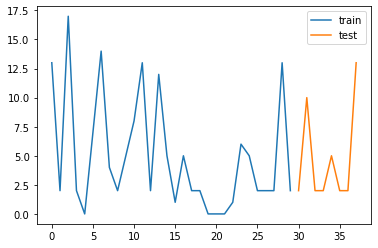

In [38]:
plt.plot(range(len(train)), train['total_points'], label='train')
plt.plot(range(len(train), len(train + test)), test['total_points'], label='test')
plt.legend();

In [39]:
X_train = train.drop('total_points', axis=1).copy()
y_train = train[['total_points']].copy()

print(X_train.shape, y_train.shape)

(30, 42) (30, 1)


In [40]:
Xscaler = MinMaxScaler(feature_range=(0, 1))
scaled_X_train = Xscaler.fit_transform(X_train)
print(X_train.shape)

Yscaler = MinMaxScaler(feature_range=(0, 1))
scaled_y_train = Yscaler.fit_transform(y_train)
print(scaled_y_train.shape)

scaled_y_train = scaled_y_train.reshape(-1)
print(scaled_y_train.shape)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

(30, 42)
(30, 1)
(30,)


In [41]:
n_input = 3 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 3 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

print(generator[0][0].shape)

(3, 3, 42)


## Build LSTM model

In [42]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150)               115800    
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 115,951
Trainable params: 115,951
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit_generator(generator,epochs=20)

Epoch 1/20


C:\Users\gracj\AppData\Local\Temp\ipykernel_9732\2163120762.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20)


9/9 [==============================] - 1s 2ms/step - loss: 0.1108
Epoch 2/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0666
Epoch 3/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0504
Epoch 4/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 5/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 6/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 7/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 9/20
9/9 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 10/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 11/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 12/20
9/9 [==============================] - 0s 2ms/step - loss: 7.3646e-04
Epoch 13/20
9/9 [==============================] - 0s 2ms/step - loss: 4.2819e-0

In [44]:
X_test = test.drop('total_points', axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

print(test_generator[0][0].shape)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)


print(test[['total_points']].values[n_input:].reshape(-1))
print(y_pred.ravel())

y_pred_0 = y_pred

results_0 = pd.DataFrame({'y_true':test[['total_points']].values[n_input:].reshape(-1),'y_pred':y_pred.ravel()})
print(results_0)

(3, 3, 42)
[ 2  5  2  2 13]
[2.0237687 2.106643  5.6016316 1.1391746 2.0175688]
   y_true    y_pred
0       2  2.023769
1       5  2.106643
2       2  5.601632
3       2  1.139175
4      13  2.017569


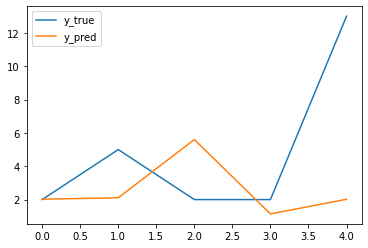

In [45]:
results_0.plot();

## Add Jamie Vardy understat data and train new model

In [46]:
data_path = os.path.dirname(os.getcwd()) + '\\data\\Fantasy-Premier-League'
vardy_understat = data_path + '\\2021-22\\understat\\Jamie_Vardy_755.csv'
vardy_understat = pd.read_csv(vardy_understat, encoding='latin-1', )
vardy_understat.head()

,goals,shots,xG,time,position,h_team,a_team,h_goals,a_goals,date,id,season,roster_id,xA,assists,key_passes,npg,npxG,xGChain,xGBuildup
0,0,0,0.000000,62,FW,Leicester,Leeds,1,0,2022-03-05,16648,2021,517260,0.000000,0,0,0,0.000000,0.000000,0.000000
1,1,2,0.474730,16,Sub,Burnley,Leicester,0,2,2022-03-01,16588,2021,517091,0.087236,1,2,1,0.474730,0.561967,0.000000
2,0,2,0.149755,90,FW,Leicester,Liverpool,1,0,2021-12-28,16573,2021,505323,0.320443,0,1,0,0.149755,0.470198,0.000000
3,0,0,0.000000,22,Sub,Aston Villa,Leicester,2,1,2021-12-05,16516,2021,500887,0.000000,0,0,0,0.000000,0.000000,0.000000
4,0,3,0.508952,90,FW,Southampton,Leicester,2,2,2021-12-01,16514,2021,499112,0.101893,0,2,0,0.508952,0.594523,0.160227


In [47]:
# clean what's after "T" in the kickoff_time column from vardy_data
vardy_data['date'] = vardy_data['kickoff_time'].str.split('T').str[0]
vardy_data.drop(['kickoff_time'], axis=1, inplace=True)

C:\Users\gracj\AppData\Local\Temp\ipykernel_9732\4273698592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vardy_data['date'] = vardy_data['kickoff_time'].str.split('T').str[0]
C:\Users\gracj\AppData\Local\Temp\ipykernel_9732\4273698592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vardy_data.drop(['kickoff_time'], axis=1, inplace=True)


In [48]:
vardy_data_understat = vardy_data.merge(vardy_understat, on='date', how='left')

In [49]:
vardy_data_understat.columns

Index(['name', 'position_x', 'team', 'xP', 'assists_x', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'GW', 'date', 'goals', 'shots',
       'xG', 'time', 'position_y', 'h_team', 'a_team', 'h_goals', 'a_goals',
       'id', 'season', 'roster_id', 'xA', 'assists_y', 'key_passes', 'npg',
       'npxG', 'xGChain', 'xGBuildup'],
      dtype='object')

In [50]:
vardy_data_understat = vardy_data_understat.drop(['goals', 'time', 'position_y', 'h_team', 'a_team', 'h_goals', 'a_goals', 'id', 'season', 'roster_id', 'assists_y'], axis=1)

In [51]:
# insert 0's for missing values
vardy_data_understat.fillna(0, inplace=True)

In [52]:
vardy_data_understat.head()

,name,position_x,team,xP,assists_x,bonus,bps,clean_sheets,creativity,element,...,GW,date,shots,xG,xA,key_passes,npg,npxG,xGChain,xGBuildup
0,Jamie Vardy,FWD,Leicester,4.8,0,3,52,1,10.3,224,...,1,2020-09-13,2.0,1.522338,0.066219,1.0,0.0,0.000000,0.112795,0.046576
1,Jamie Vardy,FWD,Leicester,8.0,0,0,6,0,11.2,224,...,2,2020-09-20,1.0,0.089161,0.096211,1.0,0.0,0.089161,0.277284,0.091911
2,Jamie Vardy,FWD,Leicester,10.2,0,3,82,0,0.5,224,...,3,2020-09-27,3.0,1.965583,0.000000,0.0,1.0,0.443245,0.521428,0.078183
3,Jamie Vardy,FWD,Leicester,9.0,0,0,-2,0,1.4,224,...,4,2020-10-04,1.0,0.302199,0.000000,0.0,0.0,0.302199,0.302199,0.000000
4,Jamie Vardy,FWD,Leicester,4.3,0,0,0,0,0.0,224,...,5,2020-10-18,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


## Do data preprocessing and build model again, with understat data

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               109800    
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 109,951
Trainable params: 109,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


C:\Users\gracj\AppData\Local\Temp\ipykernel_9732\4227821409.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=20)


9/9 [==============================] - 1s 2ms/step - loss: 0.0927
Epoch 2/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0716
Epoch 3/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0445
Epoch 4/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0366
Epoch 5/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 6/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 7/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 8/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 9/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 10/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 11/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 12/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 13/20
9/9 [==============================] - 0s 2ms/step - loss: 9.6631e-04
Ep

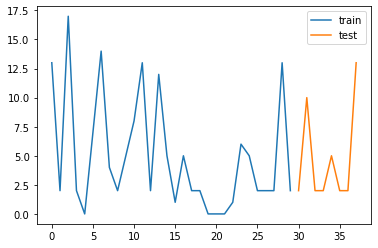

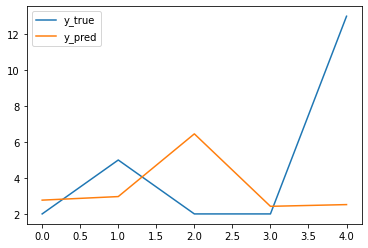

In [53]:
## Data preprocessing
cleaned_data_understat = vardy_data_understat.drop(
    ['name', 'position_x', 'team', 'element', 'fixture', 'date', 'saves', 'penalties_saved', 'round', 'GW'],
    axis=1)

cleaned_data_understat = cleaned_data_understat.drop(['opponent_team'], axis=1)   

# change was_home column to binary
cleaned_data_understat['was_home'] = cleaned_data_understat['was_home'].map({True: 1, False: 0})

# one hot encode 'opponent_team' column
#cleaned_data_understat = pd.get_dummies(cleaned_data_understat, columns=['opponent_team'], drop_first=True)

train = cleaned_data_understat[:30]
test = cleaned_data_understat[30:]

plt.plot(range(len(train)), train['total_points'], label='train')
plt.plot(range(len(train), len(train + test)), test['total_points'], label='test')
plt.legend();

X_train = train.drop('total_points', axis=1).copy()
y_train = train[['total_points']].copy()

Xscaler = MinMaxScaler(feature_range=(0, 1))
scaled_X_train = Xscaler.fit_transform(X_train)

Yscaler = MinMaxScaler(feature_range=(0, 1))
scaled_y_train = Yscaler.fit_transform(y_train)

scaled_y_train = scaled_y_train.reshape(-1)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)
n_input = 3  #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = X_train.shape[1]  # how many predictors/Xs/features we have to predict y
b_size = 3  # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

## Build LSTM model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit_generator(generator, epochs=20)
X_test = test.drop('total_points', axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

y_pred_1 = y_pred

print(test[['total_points']].values[n_input:].reshape(-1))
print(y_pred.ravel())

results_1 = pd.DataFrame({'y_true': test[['total_points']].values[n_input:].reshape(-1), 'y_pred': y_pred.ravel()})
print(results_1)
results_1.plot();

## Compare predictions with understat data and without

   y_true  y_pred_without  y_pred_understat
0       2        2.023769          2.766940
1       5        2.106643          2.964801
2       2        5.601632          6.454776
3       2        1.139175          2.422499
4      13        2.017569          2.518607


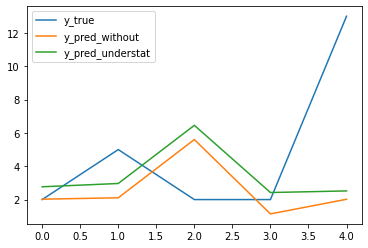

In [54]:
results_compare = pd.DataFrame({'y_true': test[['total_points']].values[n_input:].reshape(-1), 'y_pred_without': y_pred_0.ravel(), 'y_pred_understat': y_pred_1.ravel()})
print(results_compare)
results_compare.plot();

## Add Jamie Vardy data from 2019-20 season

In [55]:
merged_gw_1920_path = data_path + '\\2019-20\\gws\\merged_gw.csv'

In [56]:
merged_gw1920 = pd.read_csv(merged_gw_1920_path, encoding='latin-1')

In [57]:
merged_gw1920.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Aaron_Cresswell_376,0,0,7,0,1.5,376,8,5,0,...,0.0,0.0,0,0,0,0,50,True,0,1
1,Aaron_Lennon_430,0,0,3,0,0.0,430,3,0,0,...,3.0,0.0,1,0,0,0,50,True,0,1
2,Aaron_Mooy_516,0,0,0,0,0.0,516,7,0,0,...,0.0,0.0,0,0,0,0,50,False,0,1
3,Aaron_Ramsdale_494,0,0,11,0,0.0,494,2,1,0,...,1.0,0.0,2,0,0,0,45,True,0,1
4,Aaron_Wan-Bissaka_122,0,2,34,1,16.1,122,9,0,0,...,4.0,2.0,8,0,0,0,55,True,0,1


In [58]:
merged_gw1920.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [59]:
# sort rows by column 'GW' ascending
merged_gw1920.sort_values(by='GW', inplace=True)

### Compare columns from 20-21 and 19-20 season data

In [60]:
merged_gw_2021.columns.difference(merged_gw1920.columns)

Index(['position', 'team', 'xP'], dtype='object')

## Extract 19-20 Jamie Vardy data

In [61]:
# extract rows where 'name' contains 'Vardy'
vardy_data1920 = merged_gw1920[merged_gw1920['name'].str.contains('Vardy')]

In [62]:
vardy_data1920.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
232,Jamie_Vardy_166,0,0,5,1,4.9,166,5,0,0,...,0.0,4.0,2,0,0,0,90,True,0,1
760,Jamie_Vardy_166,0,0,-3,0,2.3,166,14,1,0,...,1.0,10.0,2,-82257,18334,100591,90,False,0,2
1289,Jamie_Vardy_166,0,2,25,0,1.8,166,27,1,1,...,1.0,27.0,8,-78612,32101,110713,89,False,0,3
1821,Jamie_Vardy_166,1,3,63,0,13.6,166,36,1,2,...,3.0,45.0,16,-7210,49194,56404,89,True,0,4
2357,Jamie_Vardy_166,0,0,5,0,11.3,166,45,1,0,...,1.0,4.0,2,83507,136063,52556,89,False,0,5


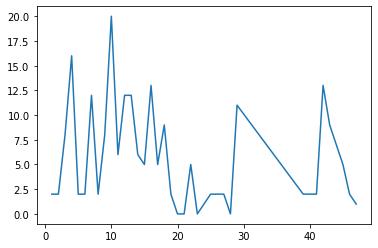

In [63]:
plt.plot(vardy_data1920['GW'], vardy_data1920['total_points']);

## Data preprocessing for merging 2 seasons data

## Add understat data 19-20

In [64]:
vardy_understat.head()

,goals,shots,xG,time,position,h_team,a_team,h_goals,a_goals,date,id,season,roster_id,xA,assists,key_passes,npg,npxG,xGChain,xGBuildup
0,0,0,0.000000,62,FW,Leicester,Leeds,1,0,2022-03-05,16648,2021,517260,0.000000,0,0,0,0.000000,0.000000,0.000000
1,1,2,0.474730,16,Sub,Burnley,Leicester,0,2,2022-03-01,16588,2021,517091,0.087236,1,2,1,0.474730,0.561967,0.000000
2,0,2,0.149755,90,FW,Leicester,Liverpool,1,0,2021-12-28,16573,2021,505323,0.320443,0,1,0,0.149755,0.470198,0.000000
3,0,0,0.000000,22,Sub,Aston Villa,Leicester,2,1,2021-12-05,16516,2021,500887,0.000000,0,0,0,0.000000,0.000000,0.000000
4,0,3,0.508952,90,FW,Southampton,Leicester,2,2,2021-12-01,16514,2021,499112,0.101893,0,2,0,0.508952,0.594523,0.160227


In [65]:
# clean what's after "T" in the kickoff_time column from vardy_data1920
vardy_data1920['date'] = vardy_data1920['kickoff_time'].str.split('T').str[0]
vardy_data1920.drop(['kickoff_time'], axis=1, inplace=True)

C:\Users\gracj\AppData\Local\Temp\ipykernel_9732\936593865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vardy_data1920['date'] = vardy_data1920['kickoff_time'].str.split('T').str[0]
C:\Users\gracj\AppData\Local\Temp\ipykernel_9732\936593865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vardy_data1920.drop(['kickoff_time'], axis=1, inplace=True)


In [66]:
vardy_data_understat_1920 = vardy_data1920.merge(vardy_understat, on='date', how='left')

In [67]:
vardy_data_understat_1920.columns

Index(['name', 'assists_x', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW', 'date', 'goals', 'shots', 'xG',
       'time', 'position', 'h_team', 'a_team', 'h_goals', 'a_goals', 'id',
       'season', 'roster_id', 'xA', 'assists_y', 'key_passes', 'npg', 'npxG',
       'xGChain', 'xGBuildup'],
      dtype='object')

In [68]:
vardy_data_understat_1920 = vardy_data_understat_1920.drop(['goals', 'time', 'position', 'h_team', 'a_team', 'h_goals', 'a_goals', 'id', 'season', 'roster_id', 'assists_y'], axis=1)

In [69]:
# insert 0's for missing values
vardy_data_understat_1920.fillna(0, inplace=True)

In [70]:
vardy_data_understat_1920.head()

,name,assists_x,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,GW,date,shots,xG,xA,key_passes,npg,npxG,xGChain,xGBuildup
0,Jamie_Vardy_166,0,0,5,1,4.9,166,5,0,0,...,1,2019-08-11,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.038629,0.038629
1,Jamie_Vardy_166,0,0,-3,0,2.3,166,14,1,0,...,2,2019-08-18,1.0,0.048942,0.000000,0.0,0.0,0.048942,0.048942,0.000000
2,Jamie_Vardy_166,0,2,25,0,1.8,166,27,1,1,...,3,2019-08-24,2.0,0.396917,0.000000,0.0,1.0,0.396917,0.419141,0.022224
3,Jamie_Vardy_166,1,3,63,0,13.6,166,36,1,2,...,4,2019-08-31,3.0,0.665877,0.639668,1.0,2.0,0.665877,1.364839,0.059293
4,Jamie_Vardy_166,0,0,5,0,11.3,166,45,1,0,...,5,2019-09-14,0.0,0.000000,0.019860,1.0,0.0,0.000000,0.019860,0.000000


In [71]:
cleaned_data_understat_1920 = vardy_data_understat_1920.drop(['name', 'date', 'element', 'fixture', 'opponent_team', 'saves', 'penalties_saved', 'round', 'GW'], axis=1)

In [72]:
# change was_home column to binary
cleaned_data_understat_1920['was_home'] = cleaned_data_understat_1920['was_home'].map({True: 1, False: 0})

In [73]:
cleaned_data_understat_1920.head()

,assists_x,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,...,was_home,yellow_cards,shots,xG,xA,key_passes,npg,npxG,xGChain,xGBuildup
0,0,0,5,1,4.9,0,0,1.6,6.8,90,...,1,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.038629,0.038629
1,0,0,-3,0,2.3,1,0,0.9,0.0,90,...,0,0,1.0,0.048942,0.000000,0.0,0.0,0.048942,0.048942,0.000000
2,0,2,25,0,1.8,1,1,6.2,33.6,90,...,0,0,2.0,0.396917,0.000000,0.0,1.0,0.396917,0.419141,0.022224
3,1,3,63,0,13.6,1,2,14.6,87.6,90,...,1,0,3.0,0.665877,0.639668,1.0,2.0,0.665877,1.364839,0.059293
4,0,0,5,0,11.3,1,0,1.7,1.2,90,...,0,0,0.0,0.000000,0.019860,1.0,0.0,0.000000,0.019860,0.000000


In [74]:
cleaned_data_understat.drop('xP', axis=1, inplace=True)
cleaned_data_understat.head()

,assists_x,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,...,was_home,yellow_cards,shots,xG,xA,key_passes,npg,npxG,xGChain,xGBuildup
0,0,3,52,1,10.3,0,2,11.8,71.2,90,...,0,0,2.0,1.522338,0.066219,1.0,0.0,0.000000,0.112795,0.046576
1,0,0,6,0,11.2,2,0,3.6,2.6,90,...,1,0,1.0,0.089161,0.096211,1.0,0.0,0.089161,0.277284,0.091911
2,0,3,82,0,0.5,2,3,17.7,105.2,84,...,0,0,3.0,1.965583,0.000000,0.0,1.0,0.443245,0.521428,0.078183
3,0,0,-2,0,1.4,3,0,1.8,2.6,90,...,1,0,1.0,0.302199,0.000000,0.0,0.0,0.302199,0.302199,0.000000
4,0,0,0,0,0.0,0,0,0.0,0.0,0,...,1,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [75]:
vardy_data_2_seasons = pd.concat([cleaned_data_understat_1920, cleaned_data_understat], axis=0)

In [76]:
vardy_data_2_seasons.shape

(76, 32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 150)               109200    
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 109,351
Trainable params: 109,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


C:\Users\gracj\AppData\Local\Temp\ipykernel_9732\3438185243.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=20)


22/22 [==============================] - 1s 2ms/step - loss: 0.0628
Epoch 2/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0366
Epoch 3/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 4/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 5/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 6/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 7/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 8/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 9/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 10/20
22/22 [==============================] - 0s 2ms/step - loss: 9.0534e-04
Epoch 11/20
22/22 [==============================] - 0s 2ms/step - loss: 6.8044e-04
Epoch 12/20
22/22 [==============================] - 0s 2ms/step - loss: 4.6330e-04
Epoch 13/20
22/22 [=============================

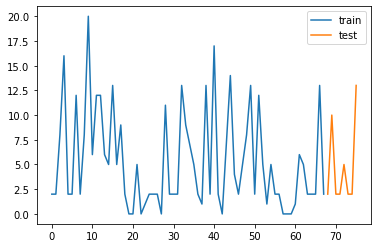

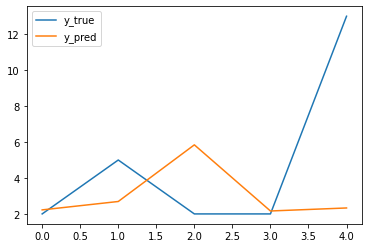

In [77]:
train = vardy_data_2_seasons[:68]
test = vardy_data_2_seasons[68:]

plt.plot(range(len(train)), train['total_points'], label='train')
plt.plot(range(len(train), train.shape[0]+test.shape[0]), test['total_points'], label='test')
plt.legend();

X_train = train.drop('total_points', axis=1).copy()
y_train = train[['total_points']].copy()

Xscaler = MinMaxScaler(feature_range=(0, 1))
scaled_X_train = Xscaler.fit_transform(X_train)

Yscaler = MinMaxScaler(feature_range=(0, 1))
scaled_y_train = Yscaler.fit_transform(y_train)

scaled_y_train = scaled_y_train.reshape(-1)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)
n_input = 3  #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = X_train.shape[1]  # how many predictors/Xs/features we have to predict y
b_size = 3  # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

## Build LSTM model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit_generator(generator, epochs=20)
X_test = test.drop('total_points', axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

y_pred_2 = y_pred

print(test[['total_points']].values[n_input:].reshape(-1))
print(y_pred.ravel())

results_1 = pd.DataFrame({'y_true': test[['total_points']].values[n_input:].reshape(-1), 'y_pred': y_pred.ravel()})
print(results_1)
results_1.plot();

## Compare results

   y_true  y_pred_without  y_pred_understat  y_pred_understat_2_seasons
0       2        2.023769          2.766940                    2.224421
1       5        2.106643          2.964801                    2.691344
2       2        5.601632          6.454776                    5.843468
3       2        1.139175          2.422499                    2.163331
4      13        2.017569          2.518607                    2.330841


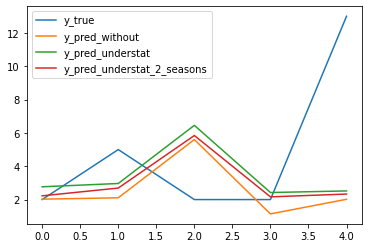

In [78]:
results_compare = pd.DataFrame({'y_true': test[['total_points']].values[n_input:].reshape(-1), 'y_pred_without': y_pred_0.ravel(), 'y_pred_understat': y_pred_1.ravel(), 
'y_pred_understat_2_seasons': y_pred_2.ravel()})
print(results_compare)
results_compare.plot();